In [1]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os, fnmatch

import keras
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM 
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [2]:
INPUT_DIR = "/content/drive/My Drive/heart/"
set_a = pd.read_csv(INPUT_DIR+"set_a.csv")
set_b = pd.read_csv(INPUT_DIR+"set_b.csv")

In [3]:
data = set_a.append(set_b, ignore_index = True)
data = data.loc[data['label'].notnull()]
data

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
827,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
828,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
829,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
830,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


In [4]:
classes=list(data.label.unique())
classes

['artifact', 'extrahls', 'murmur', 'normal', 'extrastole']

In [5]:
# shift track by random value 
def augmentation(data, sampling_rate, shift_max):
    shift = np.random.randint(sampling_rate * shift_max)
    direction = np.random.randint(0, 2)
    if direction == 1:
      shift = -shift    
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

In [6]:
# audio conversion using Mel-frequency cepstrum 
def load_audio(file_names, sound_duration=12, sample_rate=16000):
  input_length=sample_rate*sound_duration
  try:
    sound, sample_rate = librosa.load( file_names, sr=sample_rate, duration=sound_duration, res_type='kaiser_fast')
    duration = librosa.get_duration(y=sound, sr=sample_rate)
    if (round(duration) < sound_duration):
        y = librosa.util.fix_length(sound, input_length)               
  except Exception as e:
    print('File reading error')
    return ''
  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40).T,axis=0)
  feature = np.array(mfccs).reshape([-1,1])

  aug_sound = augmentation(sound, 16000, 6)
  aug_mfccs = np.mean(librosa.feature.mfcc(y=aug_sound, sr=sample_rate, n_mfcc=40).T,axis=0)
  aug_feature = np.array(aug_mfccs).reshape([-1,1])
  return feature, aug_feature


In [7]:
artifact = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
artifact = ['/set_a/'+ x for x in artifact]

normal_a = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
normal_b = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')
normal_a = ['/set_a/'+ x for x in normal_a]
normal_b = ['/set_b/'+ x for x in normal_b]
normal = normal_a + normal_b

extrahls_а = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
extrahls = ['/set_a/'+ x for x in extrahls_а]

murmur_a = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
murmur_b = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')
murmur_a = ['/set_a/'+ x for x in murmur_a]
murmur_b = ['/set_b/'+ x for x in murmur_b]
murmur = murmur_a + murmur_b

extrastole_b = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
extrastole = ['/set_b/'+ x for x in extrastole_b]

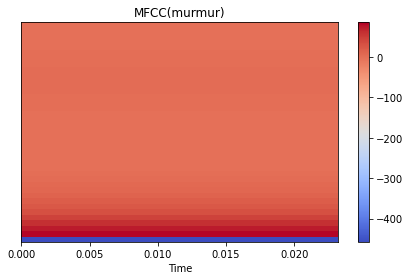

In [8]:
x, aug_x = load_audio(INPUT_DIR + murmur[6])
librosa.display.specshow(x, x_axis='time')
plt.colorbar()
plt.title("MFCC(murmur)")
plt.tight_layout()

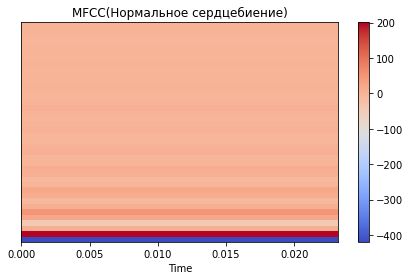

In [9]:
x, aug_x = load_audio(INPUT_DIR + normal_b[6])
librosa.display.specshow(x, x_axis='time')
plt.colorbar()
plt.title("MFCC(Нормальное сердцебиение)")
plt.tight_layout()

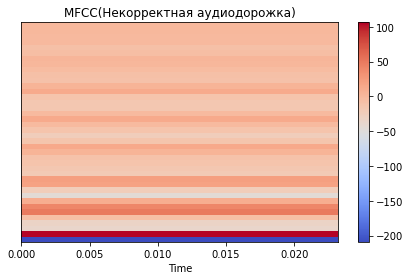

In [10]:
x, aug_x = load_audio(INPUT_DIR + artifact[2])
librosa.display.specshow(x, x_axis='time')
plt.colorbar()
plt.title("MFCC(Некорректная аудиодорожка)")
plt.tight_layout()

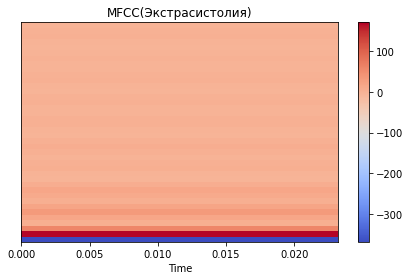

In [11]:
x, aug_x = load_audio(INPUT_DIR + extrastole[12])
librosa.display.specshow(x, x_axis='time')
plt.colorbar()
plt.title("MFCC(Экстрасистолия)")
plt.tight_layout()

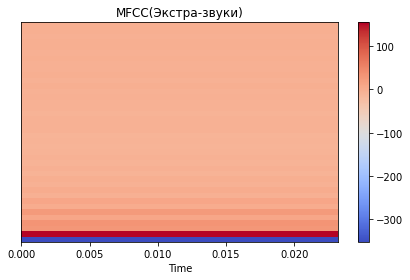

In [12]:
x, aug_x = load_audio(INPUT_DIR + extrahls[2])
librosa.display.specshow(x, x_axis='time')
plt.colorbar()
plt.title("MFCC(Экстра-звуки)")
plt.tight_layout()

In [13]:
X_name = artifact + normal + extrahls + murmur + extrastole
y_name = [classes.index('artifact')]*len(artifact) + [classes.index('normal')]*len(normal) 
y_name += [classes.index('extrahls')]*len(extrahls) + [classes.index('murmur')]*len(murmur) + [classes.index('extrastole')]*len(extrastole)


In [14]:
X = []
y = []
aug_X = []
for i in range(len(X_name)):  
  try:
    x, aug_x = load_audio(INPUT_DIR + X_name[i])
  except:
    continue
  if x.any():
    X.append(x)
    aug_X.append(aug_x)
    y.append(y_name[i])
    x = []

In [15]:
y_bin = utils.to_categorical(y, len(classes))
y_data = np.concatenate((y_bin, y_bin))
X_data = np.concatenate((X, aug_X))

x_train, x_val, y_train, y_val = train_test_split(X_data,
                                                  y_data, 
                                                  test_size=0.4, 
                                                  random_state=44)

In [16]:

model = Sequential()
model.add(Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True), input_shape=(40,1)))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, return_sequences=False)))
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 40, 128)          33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 75,333
Trainable params: 75,333
Non-trainable params: 0
_________________________________________________________________


In [17]:
PATIENT=15
EPOCHS=60
BATCH_SIZE=128

model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_acc',
                                      save_best_only=True,
                                      verbose=1)

history=model.fit(x_train, y_train, 
                  batch_size=BATCH_SIZE, 
                  epochs=EPOCHS,
                  validation_data=(x_val, y_val),
                  callbacks=checkpoint_callback) 

Epoch 1/60
5/6 [========================>.....] - ETA: 0s - loss: 1.4681 - acc: 0.4422
Epoch 00001: val_acc improved from -inf to 0.60470, saving model to best_model.h5
6/6 [==============================] - 13s 432ms/step - loss: 1.4439 - acc: 0.4644 - val_loss: 1.1859 - val_acc: 0.6047
Epoch 2/60
5/6 [========================>.....] - ETA: 0s - loss: 1.1796 - acc: 0.5938
Epoch 00002: val_acc did not improve from 0.60470
6/6 [==============================] - 0s 60ms/step - loss: 1.1725 - acc: 0.5969 - val_loss: 1.0918 - val_acc: 0.6047
Epoch 3/60
5/6 [========================>.....] - ETA: 0s - loss: 1.0885 - acc: 0.6000
Epoch 00003: val_acc did not improve from 0.60470
6/6 [==============================] - 0s 61ms/step - loss: 1.0854 - acc: 0.5983 - val_loss: 1.0313 - val_acc: 0.6047
Epoch 4/60
5/6 [========================>.....] - ETA: 0s - loss: 1.0349 - acc: 0.5969
Epoch 00004: val_acc improved from 0.60470 to 0.61111, saving model to best_model.h5
6/6 [========================

In [18]:
model.load_weights(model_save_path)

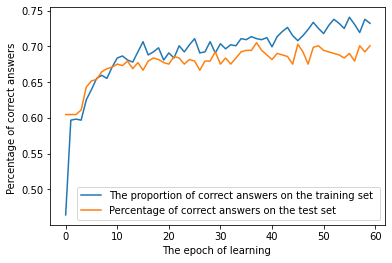

In [19]:
plt.plot(history.history['acc'], 
         label='The proportion of correct answers on the training set ')
plt.plot(history.history['val_acc'], 
         label='Percentage of correct answers on the test set')
plt.xlabel('The epoch of learning ')
plt.ylabel('Percentage of correct answers ')
plt.legend()
plt.show()

In [20]:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  72 %
model validation data score  :  71 %


In [21]:
model.save('heart1.h5')